Charles Le Losq
Friday, 22 May 2015
Modified the 16 June 2015.

Geophysical Laboratory,
Carnegie Institution for Science

Example of use of pysolex, the library using the software SolEx developped by Fred Witham, University of Bristol.

From the header of the solex.cpp:

"An object that calculates the solubility relationships for basalt given basalt compositional parameters and PT conditions."

Difference with the SolEx GUI software:
- C++ code modified to perform only equilibrium calculation at given P, T, X. 
- The core library is written in C++, only functional modifications have been made, the calculation stays as it was written by Fred Witham.
- The C++ library SolEx is not directly wrapped to keep it running without modification and for simplifying the wrapping process. Rather than a direct wrapping, I created a function pysolex.cpp that is wrapped using SWIG. Then, in the setup.py file, the distutils function calls the wrapped version of pysolex.cpp with knowing that it has to use libsolex.a! This allows to keep a clean C++ code for the SolEx core library that can be used independently of Python.
- Results are in a SWIG array... For now, I only found a way to have them: directly reading the memory block were they are stored with ctypes... It's working but such low level in Python seems not ideal (=nice) to me?

Let's start and call the useful libraries:


In [1]:
import numpy as np #for handling the numbers/arrays
import scipy #for a lot of scientific stuffs, optimisation, interpolation functions, etc.
import pysolex #we import the pysolex library!
import ctypes #for reading the SWIG array output
import matplotlib #for doing nice graphs
import matplotlib.pyplot as plt # For doing the plots
from pylab import * #for doing nice graphs
# We need this in this case because we use IPython notebooks, but not needed in a .py code
%matplotlib inline 

Ok, now we start by defining a starting chemical composition of interest (warning to put dots so that Python interpretes the numbers as float and not int!):

In [2]:
CO2 = 4890.
H2O = 3.67
PPMS0 = 3560.
PPMCl0 = 1572.
Si = 52.12
Al = 16.38
Fe = 5.82
Ca = 10.72
Mg = 6.71
Na = 2.47
K = 1.89

Now we define the value of pi to use, which is the parameterisation described in Dixon(1997). This value is not used unless piswitch is set to 1. 

In [3]:
pi = -0.05341

Below is the wt% of SiO2 that was used for the SiO2 only parameterisation. From Fred: "I think (I should check but dont have the code available now) that this is no-longer used as the SiO2 wt% is calculated from Si mol%."

In [4]:
SiO2 = 52.12 #should match the good value

Now the pisol switch: if 1 solubility is based on the value of pi, if 0 it is used on SiO2 wt% only.

In [5]:
pisol = 0

Now a second switch to determine if pisol is given or should be calculated: if 1 then the value pi is used for solubility calculations, and if 0 pi is calculated from the composition of the melt.

In [6]:
piswitch = 0

Now let's fix the other parameters of our system: temperature, pressure, and oxygen fugacity! We will start with a fixed oxygen fugacity, pressure and temperature:

In [7]:
T = 1153.; #in K
P = 100.; #in bars
NNO = 1.8;

Ok, for this single calculation, SolEx has a flag for terminal output, but it is not working in the Notebook. So let's put the flag to 0:

In [8]:
flagout = bool(0) #has to be a bool value

And the function to call is pysolex.pyex:

In [9]:
output = pysolex.pyex(H2O,CO2,PPMS0,PPMCl0,Si,Al,Fe,Ca,Mg,Na,K,pi,SiO2,pisol,piswitch,flagout,T,P,NNO)
output

<Swig Object of type 'double *' at 0x104ec6de0>

Oh... Here is the result contained in output => a SWIG Object containing double number... To read it, I only found one way online: reading directly the memory block allocated to this Ojbect using ctypes:

In [10]:
rawPointer = output.__long__() # we're going to read the "address"
pC = ctypes.cast(rawPointer, ctypes.POINTER( ctypes.c_double )) # and we read the array stored at this address
print(("wt% H2O = "+str(pC[0])))
print(("PPM CO2 = "+str(pC[1])))
print(("PPM S = "+str(pC[2])))
print(("PPM Cl = "+str(pC[3])))
print(("Vol% Exsolve = "+str(pC[4])))
print(("XV H2O (mass) = "+str(pC[5])))
print(("XV CO2 (mass) = "+str(pC[6])))
print(("XV S (mass) = "+str(pC[7])))
print(("XV Cl (mass) = "+str(pC[8])))
print(("molV H2O (mass) = "+str(pC[9])))
print(("molV CO2 (mass) = "+str(pC[10])))
print(("molV S (mass) = "+str(pC[11])))
print(("molV Cl (mass) = "+str(pC[12])))


wt% H2O = 0.98987741142
PPM CO2 = 2.74547200339
PPM S = 0.0290543523075
PPM Cl = 1397.16576496
Vol% Exsolve = 85.0234203264
XV H2O (mass) = 0.756599096781
XV CO2 (mass) = 0.137967284682
XV S (mass) = 0.100498044885
XV Cl (mass) = 0.00493557365189
molV H2O (mass) = 7.23188901801
molV CO2 (mass) = 0.0292865664245
molV S (mass) = 0.0240400681552
molV Cl (mass) = 0.0


Ok, it's working. Now let's complicate the case. Let's imagine that we have a closed-system degassing, going from P = 4000 to 100 bar, as you can do in SolEx. You will write something like that to reproduce the calculation in Python:

In [11]:
Pint = np.arange(100,4000,100) #start, stop, step
rev_Pint = Pint[::-1] # To have the first values being the highest ones
results = np.zeros((len(Pint),13)) # For storing the results

We create a loop in which we will call pysolex for doing the calculation:

In [12]:
for i in range(len(rev_Pint)):
    output = pysolex.pyex(H2O,CO2,PPMS0,PPMCl0,Si,Al,Fe,Ca,Mg,Na,K,pi,SiO2,pisol,piswitch,flagout,T,rev_Pint[i],NNO)
    rawPointer = output.__long__()
    pC = ctypes.cast(rawPointer, ctypes.POINTER( ctypes.c_double ))
    
    results[i,0] = pC[0] #wt% water
    results[i,1] = pC[1] #co2 ppm
    results[i,2] = pC[2] #S ppm
    results[i,3] = pC[3] #Cl ppm
    results[i,4] = pC[4] #EXSOLVE
    results[i,5] = pC[5] #XV H2O
    results[i,6] = pC[6] #XV CO2
    results[i,7] = pC[7] #XV S
    results[i,8] = pC[8] #XV Cl
    results[i,9] = pC[9] #molV H2O
    results[i,10] = pC[10] #molV CO2
    results[i,11] = pC[11] #molV S
    results[i,12] = pC[12] #molV Cl


Done! Let's do a nice graph for those results:

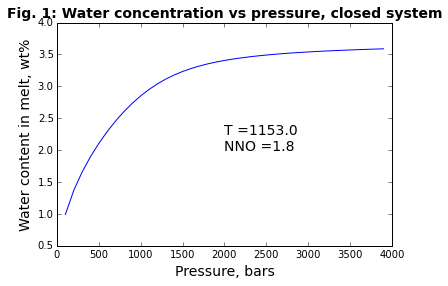

In [13]:
plt.plot(rev_Pint[:],results[:,0])
plt.xlabel("Pressure, bars", fontsize = 14)
plt.ylabel("Water content in melt, wt%", fontsize = 14)
plt.title("Fig. 1: Water concentration vs pressure, closed system",fontsize = 14,fontweight = "bold")
plt.text(2000,2,("T ="+str(T)+"\nNNO ="+str(NNO)),fontsize = 14)

Let's do the same thing for the CO2 now:

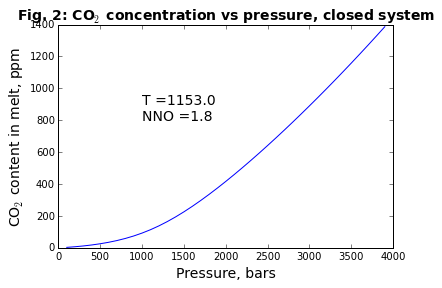

In [14]:
plt.plot(rev_Pint[:],results[:,1])
plt.xlabel("Pressure, bars", fontsize = 14)
plt.ylabel("CO$_2$ content in melt, ppm", fontsize = 14)
plt.title("Fig. 2: CO$_2$ concentration vs pressure, closed system",fontsize = 14,fontweight = "bold")
plt.text(1000,800,("T ="+str(T)+"\nNNO ="+str(NNO)),fontsize = 14)

Now let's make the case of an open system. Easy, we will just take the H2O, CO2, S and Cl values from the past output to input them in the next...

In [15]:
for i in range(len(rev_Pint)):
    if i == 0:
        output = pysolex.pyex(H2O,CO2,PPMS0,PPMCl0,Si,Al,Fe,Ca,Mg,Na,K,pi,SiO2,pisol,piswitch,flagout,T,rev_Pint[i],NNO)
    else:
        H2O = results[i-1,0]
        CO2 = results[i-1,1]
        PPMS = results[i-1,2]
        PPMCl = results[i-1,3]
        output = pysolex.pyex(H2O,CO2,PPMS,PPMCl,Si,Al,Fe,Ca,Mg,Na,K,pi,SiO2,pisol,piswitch,flagout,T,rev_Pint[i],NNO)
        
    rawPointer = output.__long__()
    pC = ctypes.cast(rawPointer, ctypes.POINTER( ctypes.c_double ))
    
    results[i,0] = pC[0] #wt% water
    results[i,1] = pC[1] #co2 ppm
    results[i,2] = pC[2] #S ppm
    results[i,3] = pC[3] #Cl ppm
    results[i,4] = pC[4] #EXSOLVE
    results[i,5] = pC[5] #XV H2O
    results[i,6] = pC[6] #XV CO2
    results[i,7] = pC[7] #XV S
    results[i,8] = pC[8] #XV Cl
    results[i,9] = pC[9] #molV H2O
    results[i,10] = pC[10] #molV CO2
    results[i,11] = pC[11] #molV S
    results[i,12] = pC[12] #molV Cl

We can now plot the results as we did for the closed system case:

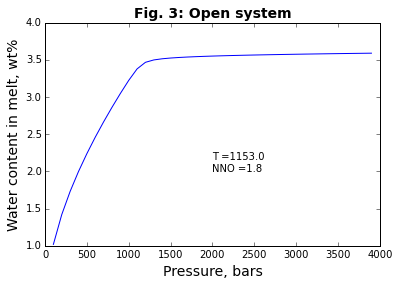

In [16]:
plt.plot(rev_Pint[:],results[:,0])
plt.xlabel("Pressure, bars", fontsize = 14)
plt.ylabel("Water content in melt, wt%", fontsize = 14)
plt.title("Fig. 3: Open system ",fontsize = 14,fontweight = "bold")
plt.text(2000,2,("T ="+str(T)+"\nNNO ="+str(NNO)))

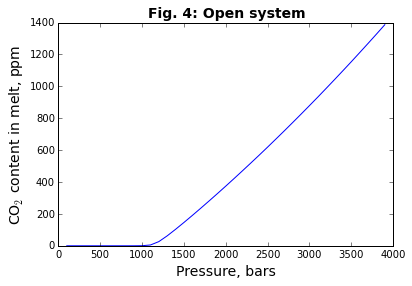

In [17]:
plt.plot(rev_Pint[:],results[:,1])
plt.xlabel("Pressure, bars", fontsize = 14)
plt.ylabel("CO$_2$ content in melt, ppm", fontsize = 14)
plt.title("Fig. 4: Open system ",fontsize = 14,fontweight = "bold")
#plt.text(1000,800,("T ="+str(T)+"\nNNO ="+str(NNO)))

In [18]:
results[0,0]

3.5889504867610182

In [19]:
rev_Pint[0]

3900